## Imports ##

In [1]:
import pandas as pd
import numpy as np
# import torch

## Feature engineering ##

In [ ]:
def create_features(current_meet, previous_meet):
    features = current_meet.copy()

    features['prev_squat'] = previous_meet['Best3SquatKg'].iloc[-1]
    features['prev_bench'] = previous_meet['Best3BenchKg'].iloc[-1]
    features['prev_deadlift'] = previous_meet['Best3DeadliftKg'].iloc[-1]

    features['avg_squat'] = previous_meet['Best3SquatKg'].mean()
    features['avg_bench'] = previous_meet['Best3BenchKg'].mean()
    features['avg_deadlift'] = previous_meet['Best3DeadliftKg'].mean()
    
    features['days_since_last_meet'] = (
        pd.to_datetime(current_meet['Date']) - pd.to_datetime(previous_meet['Date'].iloc[-1])
    ).days
    features['total_meets'] = len(previous_meet)
    
    # total kg lifted to bodyweight ratio on previous meet
    features['total_bodyweight_ratio'] = previous_meet['TotalKg'].iloc[-1] / previous_meet['BodyweightKg'].iloc[-1]
    
    if len(previous_meet) >= 2:
        features['percent_gain_since_last'] = (
            (previous_meet['TotalKg'].iloc[-1] - previous_meet['TotalKg'].iloc[-2]) / 
            previous_meet['TotalKg'].iloc[-2]
        )
        features['career_avg_improvement_rate'] = (
            (previous_meet['TotalKg'].iloc[-1] - previous_meet['TotalKg'].iloc[0]) / 
            previous_meet['TotalKg'].iloc[0] / (len(previous_meet) - 1)
        )
    else:
        features['percent_gain_since_last'] = 0
        features['career_avg_improvement_rate'] = 0
    
    features['total_std'] = previous_meet['TotalKg'].std() if len(previous_meet) > 1 else 0
    
    return features

## Create features for one lifter and all lifters (run above first to confirm features to engineer)

In [ ]:
def process_single_lifter(lifter_data):
    lifting_data = []

    for i in range(1, len(lifter_data)):
        current = lifter_data.iloc[i]
        previous = lifter_data.iloc[:i]
        features = create_features(current, previous)
        lifting_data.append(features)
    return pd.DataFrame(lifting_data)

def engineer_features(df, meets=3):
    print(f'Total lifters: {df["Name"].nunique()}')

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Name', 'Date']).reset_index(drop=True) # sort by name, date
    all_lifting_data = []

    for name, lifter_data in df.groupby('Name'): # for each lifters competition history
        if len(lifter_data) < meets: # only can predict lifters with at least two comp history
            continue
        features = process_single_lifter(lifter_data)
        if len(lifter_data) >= 3:
            features = features.iloc[1:]
        all_lifting_data.append(features)

    result = pd.concat(all_lifting_data)

    print(f"\nFeature engineering complete!")
    print(f"Training examples created: {len(result)}")
    print(f"{result['Name'].nunique()} lifters with {meets}+ meets")
    return result

df = pd.read_csv('../data/2-preprocessed/openpowerlifting-IPF-clean_MIN.csv')

df_with_features = engineer_features(df)
df_with_features.to_csv('../data/3-features/IPF_features_train_test_new.csv', index=False)



Total lifters: 158815

Feature engineering complete!
Training examples created: 139293
42871 lifters with 2+ meets


## DATASET SPLIT

In [31]:
df = pd.read_csv('../data/3-features/IPF_features_train_test_new.csv')
df.isnull().sum()


Name                                0
Date                                0
Sex                                 0
Age                             22400
BodyweightKg                       47
Division                            0
Best3SquatKg                        0
Best3BenchKg                        0
Best3DeadliftKg                     0
TotalKg                             0
prev_squat                          0
prev_bench                          0
prev_deadlift                       0
avg_squat                           0
avg_bench                           0
avg_deadlift                        0
days_since_last_meet                0
total_meets                         0
total_bodyweight_ratio             54
percent_gain_since_last             0
avg_improvement_rate           139293
total_std                           0
career_avg_improvement_rate         0
dtype: int64

In [ ]:
df_with_features = pd.read_csv('../data/3-features/IPF_features_train_test_new.csv')
# sort by date, to prepare for training
df_with_features['Date'] = pd.to_datetime(df_with_features['Date'])
df_with_features = df_with_features.sort_values('Date').reset_index(drop=True)

split_dataset = df_with_features['Date'].quantile(0.8)

train_df = df_with_features[df_with_features['Date'] < split_dataset].copy()
train_df = train_df[(train_df['TotalKg'] >= 200) & (train_df['TotalKg'] <= 800)] # test removing outliers
test_df = df_with_features[df_with_features['Date'] >= split_dataset]

print(f'train {train_df["Date"].min()} - {train_df["Date"].max()}')
print(f'test {test_df["Date"].min()} - {test_df["Date"].max()}')

train 1969-03-02 00:00:00 - 2024-03-21 00:00:00
test 2024-03-22 00:00:00 - 2025-09-21 00:00:00


## SELECT FEATURES, ENCODING, IMPUTATION

In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

feature_columns = [
    'prev_squat', 'prev_bench', 'prev_deadlift', 
    'avg_squat', 'avg_bench', 'avg_deadlift',
    'total_meets','days_since_last_meet',
    'total_bodyweight_ratio', #'bodyweight_change',
    'percent_gain_since_last', 'career_avg_improvement_rate', 'total_std',
    'Age',
    # 'Sex_M', 'Sex_F',
]

# label/ordinal encoding can lead to model learning that there's a relationship between these categories, 
# as these sex/gender has no relationship, avoid using to prevent this
# but this works on xgboosts with 'enable_categorical'
train_df['Sex'] = train_df['Sex'].map({'M': 1, 'F': 0})
feature_columns.append('Sex')
train_df['Sex'].astype('category')

'''BUCKETIZE AGE WITH DIVISION GROUPS?? but implications with so many possible divisions'''
# drop age, too many missing values for imputation, not using for training
# train_df = train_df.drop(columns=['Age'])

# fill na with 0? over 30k rows of missing age, IMPUTE INSTEAD
# imputation methods
imputation = SimpleImputer(strategy='mean')
# train_df['BodyweightKg'] = imputation.fit_transform(train_df[['BodyweightKg']])
cols = ['BodyweightKg', 'Age']
train_df[cols] = imputation.fit_transform(train_df[cols])
print(imputation.statistics_)

train_df[feature_columns] = train_df[feature_columns].fillna(0)
print(train_df.isnull().sum())
# correlation = train_df.corr(numeric_only=True)
# correlation['TotalKg'].sort_values(ascending=False)


[82.25524464 30.36655583]
Name                                0
Date                                0
Sex                                 0
Age                                 0
BodyweightKg                        0
Division                            0
Best3SquatKg                        0
Best3BenchKg                        0
Best3DeadliftKg                     0
TotalKg                             0
prev_squat                          0
prev_bench                          0
prev_deadlift                       0
avg_squat                           0
avg_bench                           0
avg_deadlift                        0
days_since_last_meet                0
total_meets                         0
total_bodyweight_ratio              0
percent_gain_since_last             0
avg_improvement_rate           107804
total_std                           0
career_avg_improvement_rate         0
dtype: int64


In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# TIME SERIES CROSS VALIDATIONS
X = train_df[feature_columns]
y = train_df['TotalKg']
rmse_score = []
y_pred_list = []
y_actual_list = []

tscv = TimeSeriesSplit(n_splits=5)
for index, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_validate = X.iloc[train_index], X.iloc[test_index]
    y_train, y_validate = y.iloc[train_index], y.iloc[test_index]

    gbr = XGBRegressor(
        tree_method="hist",
        enable_categorical=True, 
        max_depth=8,    # prev 5
        learning_rate=0.1,  # prev 0.3
        n_estimators=100,  # new
        subsample=1,    # prev 0.8
        colsample_bytree=0.9,   # prev 0.8
        reg_lambda=100, # new
        reg_alpha=0.15, # new
        gamma=1, # new/prev 0
        random_state = 42
        )
    # gbr = LinearRegression()
    gbr.fit(X_train, y_train)
    gbr_y_pred = gbr.predict(X_validate)

    y_pred_list.extend(gbr_y_pred)
    y_actual_list.extend(y_validate)

    mae = mean_absolute_error(y_validate, gbr_y_pred)
    rmse = root_mean_squared_error(y_validate, gbr_y_pred)
    rmse_score.append(rmse)
    r2 = r2_score(y_validate, gbr_y_pred)
    print(f'Fold {index}, MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}')



Fold 0, MAE=20.28, RMSE=33.15, R2=0.951
Fold 1, MAE=20.12, RMSE=33.12, R2=0.951
Fold 2, MAE=21.05, RMSE=34.15, R2=0.947
Fold 3, MAE=21.16, RMSE=33.26, R2=0.948
Fold 4, MAE=19.52, RMSE=33.12, R2=0.948


Mean of RMSE: -33.36 ± 0.40


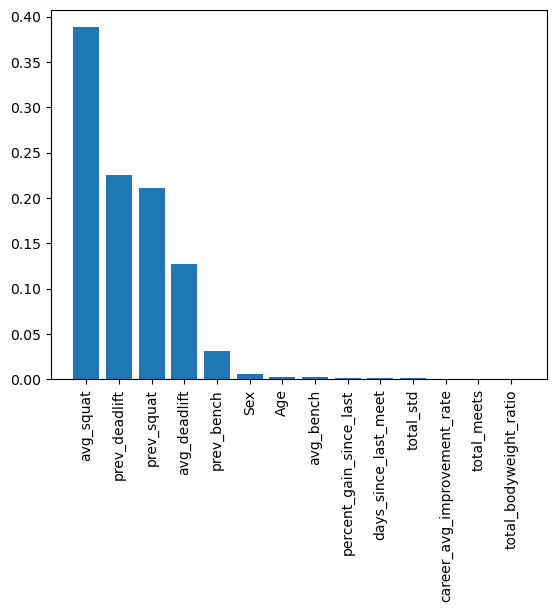

In [5]:
gbr = XGBRegressor(
    enable_categorical=True, 
    max_depth=8,    # prev 5
    learning_rate=0.1,  # prev 0.3
    n_estimators=100,  # new
    subsample=1,    # prev 0.8
    colsample_bytree=0.9,   # prev 0.8
    reg_lambda=100, # new
    reg_alpha=0.15, # new
    gamma=1, # new/prev 0
    random_state = 42
    )
# gbr = LinearRegression()

gbr.fit(X, y)
cross_val = cross_val_score(gbr, X, y, scoring='neg_root_mean_squared_error', cv=tscv)
print(f'Mean of RMSE: {cross_val.mean():.2f} ± {cross_val.std():.2f}')

importance = gbr.feature_importances_
# importance = gbr.coef_
sorted_importance = np.argsort(importance)[::-1]
x = range(len(importance))
labels = np.array(feature_columns)[sorted_importance]
plt.bar(x, importance[sorted_importance], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [6]:
print(y_validate[:5])
print(gbr_y_pred[:5])

92645    730.0
92646    460.0
92647    435.0
92648    635.0
92649    380.0
Name: TotalKg, dtype: float64
[621.1436  453.49426 449.79327 633.3631  369.06927]


In [7]:
rmse_avg = sum(rmse_score) / len(rmse_score)

print(train_df['TotalKg'].describe())
print(f"\nbaseline RMSE (always predict mean): {np.std(y):.2f}")
print(f"xgbreg model RMSE: {rmse_avg}")
print(f"improvement: {(1 - rmse_avg/np.std(y))*100:.1f}%")

count    107804.000000
mean        500.151427
std         147.904838
min         200.000000
25%         370.000000
50%         510.000000
75%         620.000000
max         800.000000
Name: TotalKg, dtype: float64

baseline RMSE (always predict mean): 147.90
xgbreg model RMSE: 33.35965888508932
improvement: 77.4%


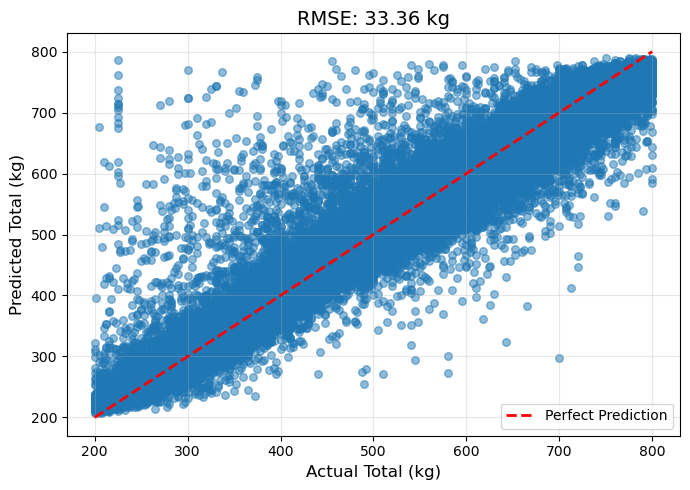

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
y_actual = np.array(y_actual_list)
y_pred = np.array(y_pred_list)
# scatter plot
ax.scatter(y_actual, y_pred, alpha=0.5, s=30)

# prediction line
min_val = min(y_actual.min(), y_pred.min())
max_val = max(y_actual.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual Total (kg)', fontsize=12)
ax.set_ylabel('Predicted Total (kg)', fontsize=12)
ax.set_title(f'RMSE: {rmse_avg:.2f} kg', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

print(XGBRegressor().get_params)
scoring = 'neg_mean_squared_error'

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9],
    'learning_rate': [0.1, 0.2, 0.3], 
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.8, 0.9, 1],
    'reg_lambda': [10, 50, 100],
    'reg_alpha': [0.15],
    'gamma': [0, 0.5, 1],
    # 'min_child_weight': [1, 3, 5]
}

xgb_model = XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring=scoring, random_state=42)
grid_search.fit(X, y)
print("Best set of HP (gridsearch): ", grid_search.best_params_)
print("Best score (GS): ", grid_search.best_score_)

random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, cv=tscv, scoring=scoring, random_state=42)
random_search.fit(X, y)

print("Best set of HP (randomsearch): ", random_search.best_params_)
print("Best score (RS): ", random_search.best_score_)
